In [1]:

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


For training model on LIVECell dataset we will use detectron2 framework, because dataset authors used it for their experiments (https://paperswithcode.com/paper/livecell-a-large-scale-dataset-for-label-free)

In [2]:
# Check PyTorch and detectron2 installation

import torch
import detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Apr_17_19:19:55_PDT_2024
Cuda compilation tools, release 12.5, V12.5.40
Build cuda_12.5.r12.5/compiler.34177558_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [3]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger

setup_logger()
import config

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

matplotlib data path: /home/vlad/miniconda3/envs/TEST/lib/python3.9/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/vlad/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/vlad/.cache/matplotlib
Using fontManager instance from /home/vlad/.cache/matplotlib/fontlist-v390.json


In [4]:
# We need to register the dataset in order to use it with detectron2 API

dataDir=Path(config.TRAIN_VAL_IMAGES)
testDataDir=Path(config.TEST_IMAGES)
cfg = get_cfg()
register_coco_instances('train_data',{}, config.TRAIN_COCO_ANNOTATIONS, dataDir)
register_coco_instances('val_data',{}, config.VAL_COCO_ANNOTATIONS, dataDir)
register_coco_instances('test_data',{}, config.TEST_COCO_ANNOTATIONS, testDataDir)
metadata = MetadataCatalog.get('train_data')
train_ds = DatasetCatalog.get('train_data')

[05/31 08:49:48 d2.data.datasets.coco]: Loading lifecell/livecell_coco_train.json takes 14.22 seconds.
[05/31 08:49:48 d2.data.datasets.coco]: Loaded 3253 images in COCO format from lifecell/livecell_coco_train.json


In [5]:
val_metadata = MetadataCatalog.get('val_data')
val_ds = DatasetCatalog.get('val_data')

[05/31 08:49:55 d2.data.datasets.coco]: Loading lifecell/livecell_coco_val.json takes 1.90 seconds.
[05/31 08:49:55 d2.data.datasets.coco]: Loaded 570 images in COCO format from lifecell/livecell_coco_val.json


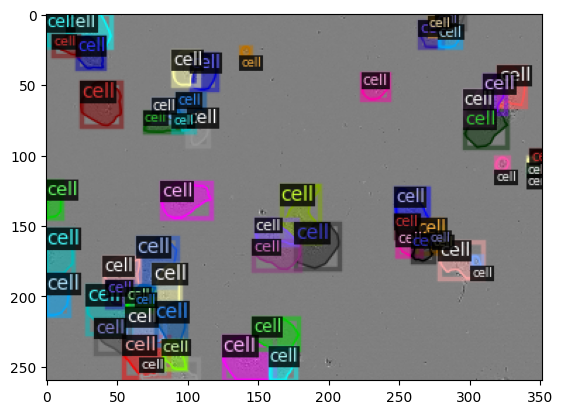

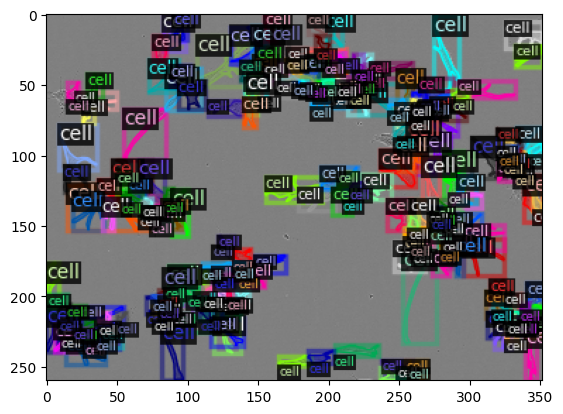

In [8]:
# Visualize some random images

for data in random.sample(train_ds, 2):
    img = cv2.imread(data['file_name'])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(data)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
# Configure the model, selecting type of model, weights, batch size, learning rate, etc.

cfg = get_cfg()
cfg.OUTPUT_DIR = config.OUTPUT_DIR   # Train results will be saved in this directory
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('train_data',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1 # batch size
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 40  
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[05/30 22:16:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains 

In [7]:
trainer.train()

[05/30 22:09:10 d2.engine.train_loop]: Starting training from iteration 0


/home/vlad/Documents/Practices/Anadea_test/.conda/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/30 22:09:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x71e1364354c0> to CPU due to CUDA OOM
[05/30 22:09:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x71e1364354c0> to CPU due to CUDA OOM
[05/30 22:09:24 d2.utils.events]:  eta: 0:00:04  iter: 19  total_loss: 2.737  loss_cls: 0.7084  loss_box_reg: 0.03176  loss_mask: 0.6868  loss_rpn_cls: 0.7048  loss_rpn_loc: 0.486    time: 0.6805  last_time: 0.2136  data_time: 0.0209  last_data_time: 0.0004   lr: 0.00011888  max_mem: 4740M
[05/30 22:09:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x71e1364354c0> to CPU due to CUDA OOM
[05/30 22:09:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x71e1364354c0> to CPU due to CUDA OOM
[05/30 22:09:35 d2.utils.events]:  eta: 0:00:00  iter: 39  total_loss: 2.385  loss_cls: 0.5475  loss_box_reg: 0.1354  loss_mask: 0.6391  loss_rpn_cls: 0.6494  loss_rpn_loc: 0.389    time: 0.5839  l

In [8]:
# we can watch the training process in tensorboard, running this command in the terminal
!tensorboard --logdir output

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [6]:
# We will save model configuration, to be able to reproduce model results
import yaml

config_yaml_path = f"{config.OUTPUT_DIR}/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)